# Load NH insolation

In [3]:
# read the insolation data '65N_inso_mean90_-1Ma_0_inter100.txt'
import pandas as pd
path='D:/VScode/Last_deglaciation/data/65N_inso_mean90_-1Ma_0_inter100.txt'
inso65n=pd.read_csv(path, sep='\s+', header=None)
# rename columns
inso65n.columns=['age', 'insolation']
# age*-1000
inso65n['age']=-1*inso65n['age']*1000
# filp the dataframe
inso65n=inso65n.iloc[::-1]


# Load sat data

In [4]:
import xarray as xr
import numpy as np

data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat_EOFs_MC = xr.open_dataset(data_dir + '/ds_sat_EOFs_MC.nc')

weight = np.cos(np.deg2rad(ds_sat_EOFs_MC['lat']))
weight = xr.where(weight < 0, 0, weight)

ds_sat_EOFs_MC['weight']=weight

# ds_sat_EOFs_MC.info

# Load sea ice data

In [5]:
path='D:/VScode/Last_deglaciation/data/LGMR_SIC_May2023.nc'

# read the nc file from the path
import xarray as xr
import numpy as np

ds_seaice = xr.open_dataset(path)
ds_seaice = ds_seaice.where(ds_seaice.age>=11000, drop=True)

# # Calculate the mean of sic along the 'age' dimension
# mean_sic = ds_seaice['sic'].isel(dims=1).mean(dim='age')
# centered_sic = ds_seaice['sic'].isel(dims=1) - mean_sic
# ds_seaice['sic_centered'] = centered_sic


# # Calculate the weight based on latitude
# weight = np.cos(np.deg2rad(ds_seaice['lat']))
# print('shape of the weight:', weight.shape)

# weight = xr.where(weight < 0, 0, weight)

# ds_seaice['weight'] = weight
# sic_centered_weighted = ds_seaice['sic_centered'] * ds_seaice['weight']
# ds_seaice['sic_centered_weighted'] = sic_centered_weighted



ds_seaice.info

shape of the weight: (96,)


c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (dims: 5, age: 65, lat: 96, lon: 144)
Coordinates:
  * lat                    (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                    (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * age                    (age) float32 1.11e+04 1.13e+04 ... 2.37e+04 2.39e+04
  * dims                   (dims) object 'mean              ' ... '97.5percen...
Data variables:
    sic                    (dims, age, lat, lon) float32 0.0 0.0 ... 0.9979
    sic_centered           (age, lat, lon) float32 0.0 0.0 ... 0.01157 0.01154
    weight                 (lat) float32 0.0 0.03306 0.06609 ... 0.03306 0.0
    sic_centered_weighted  (age, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0>

# Calculate the weighted average curve

In [6]:
import xarray as xr

ds_sat_subset = ds_sat_EOFs_MC.sel(lat=slice(-75, -60))
ds_seaice_subset = ds_seaice.sel(lat=slice(-75, -60))


weights_broadcasted = ds_sat_subset['weight'].broadcast_like(ds_sat_subset['sat'])
sum_weighted_sat = (ds_sat_subset['sat'] * weights_broadcasted).sum(dim=['lat', 'lon'])
sum_weight_sat = weights_broadcasted.sum(dim=['lat', 'lon'])

weighted_avg_sat = sum_weighted_sat / sum_weight_sat



# Calculate the area of sea ice cover

In [7]:
import numpy as np

# Constants
R = 6371  # Earth's radius in km
delta_lambda = 2.5  # longitudinal width in degrees

# Convert latitude values to radians
lat_radians = np.radians(ds_seaice_subset['lat'].values)

# Compute latitudinal boundaries
lat_boundaries = (lat_radians[:-1] + lat_radians[1:]) / 2


lat_boundaries = np.insert(lat_boundaries, 0, -np.pi/2)  # add South Pole
lat_boundaries = np.append(lat_boundaries, np.pi/2)  # add North Pole

# Compute the area of each grid cell
delta_phi = np.diff(lat_boundaries)
area_grid = 2 * np.pi * R**2 * np.outer(delta_phi, delta_lambda / 360)

# Multiply sea ice concentration by the grid cell areas to get sea ice cover
sea_ice_cover = ds_seaice_subset['sic'].isel(dims=1) * area_grid

# Sum over the lat and lon dimensions to get the total sea ice cover for the entire region
total_sea_ice_cover = sea_ice_cover.sum(dim=['lat', 'lon'])



# Load intergrated annual insolation data

In [8]:
path='D:/VScode/Last_deglaciation/data_fig3/'

# read Huybers P &Denton-2008-NGeo-65S.txt
import pandas as pd
df_inter_ann = pd.read_csv(path + 'Huybers_Denton_2008_NGeo_65S.txt', sep='\s+', header=0,skiprows=8)
# rename column NaN to age
df_inter_ann.rename(columns={'NaN':'age'}, inplace=True)
# age culumn to ka
df_inter_ann['age']=df_inter_ann['age']*1000

# IAinso=np.array([df_inter_ann['age'].values,df_inter_ann['275'].values])  
# IAinso=IAinso[:,IAinso[0,:]>0].T
# IAinso[:,0]=IAinso[:,0]*1000


# df_inter_ann.info()

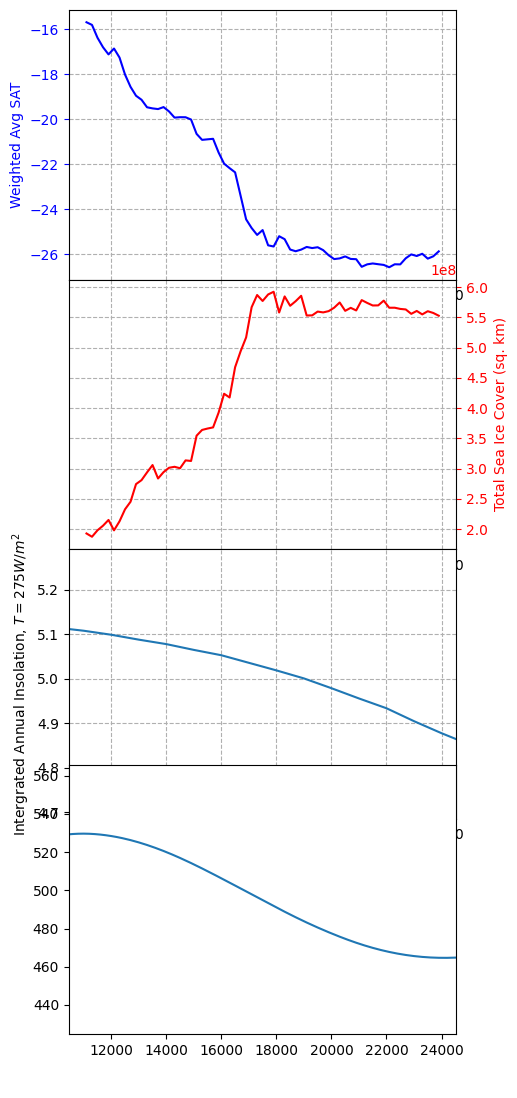

In [14]:
# Plot the average T curve and sea ice cover
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assuming you've already computed weighted_avg_sat, total_sea_ice_cover, and df_inter_ann

# Create a new figure
fig, main_ax = plt.subplots(figsize=(5, 14), dpi=100)
main_ax.axis('off')  # Turn off the main axis

# Create the inset for the Weighted Avg SAT plot
ax1 = inset_axes(main_ax, width='100%', height='100%', 
                 bbox_to_anchor=(0.05, 0.75, 1, 0.25), 
                 bbox_transform=main_ax.transAxes, borderpad=0)
ax1.plot(weighted_avg_sat['age'], weighted_avg_sat, 'b-', label="Weighted Avg SAT")
ax1.set_xlabel('Age')
ax1.set_ylabel('Weighted Avg SAT', color='b')
ax1.tick_params('y', colors='b')
ax1.grid(True, which="both", ls="--", axis="both")

# Create the inset for the Total Sea Ice Cover plot
ax2 = inset_axes(main_ax, width='100%', height='100%', 
                 bbox_to_anchor=(0.05, 0.5, 1, 0.25), 
                 bbox_transform=main_ax.transAxes, borderpad=0)
ax2.plot(total_sea_ice_cover['age'], total_sea_ice_cover, 'r-', label="Total Sea Ice Cover")
ax2.set_xlabel('Age')
ax2.set_ylabel('Total Sea Ice Cover (sq. km)', color='r')
ax2.tick_params('y', colors='r')
ax2.grid(True, which="both", ls="--", axis="both")
# show labels and ticks on the right side of the inset
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# Create the inset for the df_inter_ann data
ax3 = inset_axes(main_ax, width='100%', height='100%', 
                 bbox_to_anchor=(0.05, 0.25, 1, 0.25), 
                 bbox_transform=main_ax.transAxes, borderpad=0)

ax3.plot(df_inter_ann['age'], df_inter_ann['275'])
# for column in df_inter_ann.columns:
#     if column != 'age':
#         ax3.plot(df_inter_ann['age'], df_inter_ann[column], label=column)

ax3.set_xlabel('Age')
# ax3.set_ylabel('Intergrated Annual Insolation, T=275 W/m^2')
# rewrite the line above, show the unit in upper script
ax3.set_ylabel('Intergrated Annual Insolation, $T=275 W/m^2$')
ax3.grid(True, which="both", ls="--", axis="both")
ax3.set_xlim(ax1.get_xlim())  # Set x-axis limits same as ax1
# Uncomment the following line if you want to add a legend for df_inter_ann lines. 
# ax3.legend()

ax4 = inset_axes(main_ax, width='100%', height='100%', 
                 bbox_to_anchor=(0.05, 0.05, 1, 0.25), 
                 bbox_transform=main_ax.transAxes, borderpad=0)

ax4.plot(inso65n['age'], inso65n['insolation'])
# set xlim
ax4.set_xlim(ax1.get_xlim())

plt.show()
